In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
from pyts.approximation import PiecewiseAggregateApproximation
import matplotlib.pyplot as plt
from saxpy.znorm import znorm
from tsmoothie.smoother import LowessSmoother
import random
from saxpy.sax import ts_to_string
import string
import re
import array
from sklearn.preprocessing import MinMaxScaler
from scipy.io import arff

No handles with labels found to put in legend.


b'walking'
b'walking'
b'walking'
b'walking'
b'walking'
b'jumping'
b'jumping'
b'jumping'
b'jumping'
b'jumping'


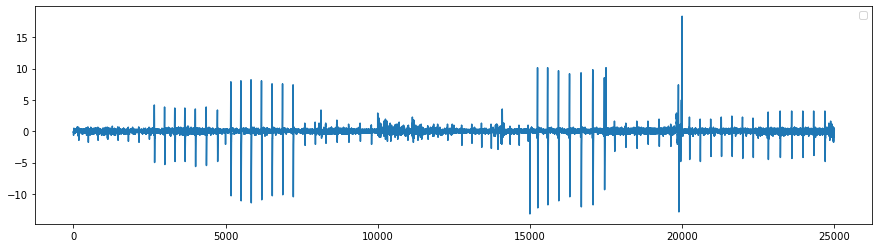

In [19]:
def read_data(index, alphabet_size):
    if index == "ecg":
        df = pd.read_csv('data/ecg_2.csv', header=None)
        ts = df.values.tolist()
        ts = ts[0:10]
        ts = sum(ts, [])
    elif index == "olive":
        ts = np.loadtxt('/Users/steffi/Downloads/OliveOil/OliveOil_Test.txt')
        ts = ts[0: 10].tolist()
        ts = [j for i in ts for j in i]
    elif index == "coffee":
        ts = np.loadtxt('/Users/steffi/Downloads/Coffee/Coffee_TEST.txt')
        ts = ts[0:100].tolist()
        ts = [j for i in ts for j in i]
    
    elif index == "traveled_miles":
        df = pd.read_csv('data/Miles_Traveled.csv')
        ts = list(df['TRFVOLUSM227NFWA'])
    
    elif index == "beer":
        df = pd.read_csv('/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/BeerWineLiquor.csv')
        ts = list(df['beer'])        
    
    elif index == "random":
        randomlist = []
        for i in range(0,2000):
            n = random.randint(1,30)
            randomlist.append(n)
            ts = randomlist
    
    elif index == "Stand":
        path = "/Users/steffi/PycharmProjects/MDL/data/StandWalkJumpDimension1_TEST.arff"
        ts = []
        data1 = arff.loadarff(open(path, 'rt'))
        list_to_append = list(range(10))
        for i in list_to_append:
            df1 = list(data1[0][i+5])
            print(df1[-1])
            df1 = df1[:-1]
            ts.extend(df1)
        
    ts = np.array(ts)
    ts = ts[1:] - ts[:-1]
    #print(ts)
    ts = znorm(ts)
    sax_numeric = get_sax_numeric(ts,alphabet_size)
    #print(sax_numeric)
    return ts, sax_numeric

ts,_ = read_data("Stand", 5)
simple_plot(ts)



In [20]:
x = "1112555555145153341244124214134222433424354425243342515222443442435232433"
np.array(x)



array('1112555555145153341244124214134222433424354425243342515222443442435232433',
      dtype='<U73')

In [21]:
def get_sax_numeric(ts,alphabet_size):
    sax = apply_sax(ts,alphabet_size)
    #print(sax)
    sax_numeric = create_number_series("".join(sax), list(string.ascii_lowercase)[0:alphabet_size])
    return sax_numeric

In [22]:
def calculate_breakpoints(ts, alphabet_size):
    breakpoints = np.quantile(ts, np.linspace(0, 0.8, alphabet_size))
    return breakpoints

In [23]:
def create_number_series(string, list_alphabet):
    for i, j in enumerate(list_alphabet):
        i += 1
        string = re.sub(str(j), str(i), string)
    return string

In [24]:
def apply_sax(ts, alphabet_size):
    breakpoints = calculate_breakpoints(ts, alphabet_size)
    sax = list(ts_to_string(ts, breakpoints))
    return sax

In [25]:
def smooth_data(data):
    smooth_fraction = 0.3

    # operate smoothing
    smoother = LowessSmoother(smooth_fraction=smooth_fraction, iterations=1)
    smoother.smooth(data)

    return list(smoother.smooth_data[0])

In [26]:
def simple_plot(ts, title="", x_label='', y_label = ''):
    plt.figure(figsize=(15, 4))
    plt.plot(list(range(len(ts))), znorm(ts), label = "")
    #plt.plot(list(range(len(ts2))), znorm(ts2), label = "votes")

    plt.title(title) #Vehicle Miles Traveled (FHWA):
    plt.ylabel(y_label, fontsize=12)
    plt.xlabel(x_label, fontsize=12)
    plt.legend()
    plt.show()

In [27]:
def multiple_line_plot(ts_list, title = '',x_label='', y_label = '', label_add = ''):
    plt.figure(figsize=(15, 4))
    plt.title(title) #Vehicle Miles Traveled (FHWA):
    for ts in ts_list:
        plt.plot(list(range(len(ts[0]))), ts[0], label = ts[1], marker = 'o')
    plt.ylabel(y_label, fontsize=12)
    plt.xlabel(x_label, fontsize=12)
    plt.legend()
    plt.show()

In [28]:
def reduce_r(ts, paa_reduction):
    ts_r = []
    ts_r_long = []
    for i in range(1, len(ts) - 1, paa_reduction):
        mean = np.mean([ts[i - 1], ts[i], ts[i + 1]])
        ts_r.append(mean)
        for i in range(paa_reduction):
            ts_r_long.append(mean)
    return list(ts_paa),ts_r_long

In [29]:
def get_ts_paa(ts, reduce_size):
    transformer = PiecewiseAggregateApproximation(window_size=reduce_size)
    ts_paa = list(transformer.transform([ts])[0])
    ts_paa_long = [reduce_size*[i] for i in ts_paa]
    ts_paa_long = sum(ts_paa_long, [])
    return ts_paa_long

In [30]:
def plot_reudced_versions(ts,ts_paa, reduce_size):
    simple_plot(ts_paa, reduce_size)

In [31]:
def plot_rms(reduction_size_list, index, kind_of_error, alphabet_size):
    ts, ts_sax = read_data(index, alphabet_size)
    list_paa = []
    list_paa_sax = []
    for reduce_size in reduction_size_list:
        ts_paa = get_ts_paa(ts, reduce_size)
        ts_paa_sax = get_sax_numeric(ts_paa,alphabet_size)
        min_len = (min([len(ts), len(ts_paa)]))
        # get error
        if kind_of_error =="mean_absolute_error":
            rms_paa = mean_squared_error(ts[0:min_len], ts_paa[0:min_len], squared=False)
            rms_paa_sax = mean_squared_error(ts_sax[0:min_len], ts_paa_sax[0:min_len], squared=False)

        elif kind_of_error =="mean_squared_error":
            rms_paa = mean_squared_error(ts[0:min_len], ts_paa[0:min_len], squared=False)
            rms_paa_sax = mean_squared_error(np.array(list(ts_sax), dtype=float)[0:min_len], np.array(list(ts_paa_sax), dtype=float)[0:min_len], squared=False)
 
        list_paa.append(rms_paa)
        list_paa_sax.append(rms_paa_sax)
    return list_paa, list_paa_sax


In [32]:
data_list = ["ecg", "olive","coffee", "traveled_miles", "random", "beer", "Stand" ]

b'walking'
b'walking'
b'walking'
b'walking'
b'walking'
b'jumping'
b'jumping'
b'jumping'
b'jumping'
b'jumping'


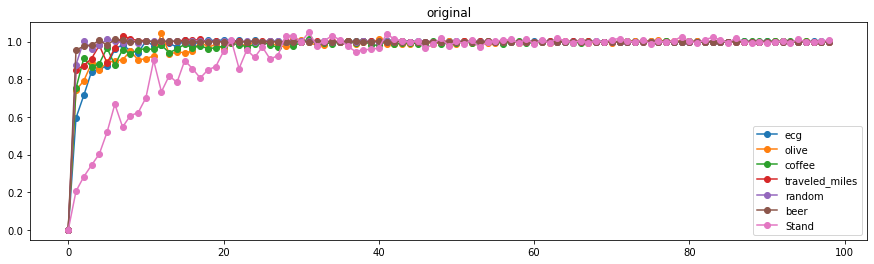

b'walking'
b'walking'
b'walking'
b'walking'
b'walking'
b'jumping'
b'jumping'
b'jumping'
b'jumping'
b'jumping'


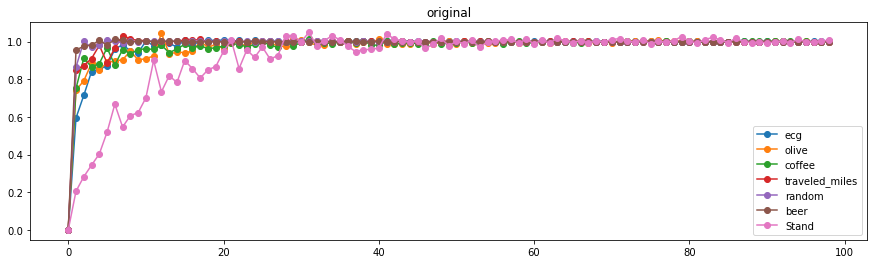

b'walking'
b'walking'
b'walking'
b'walking'
b'walking'
b'jumping'
b'jumping'
b'jumping'
b'jumping'
b'jumping'


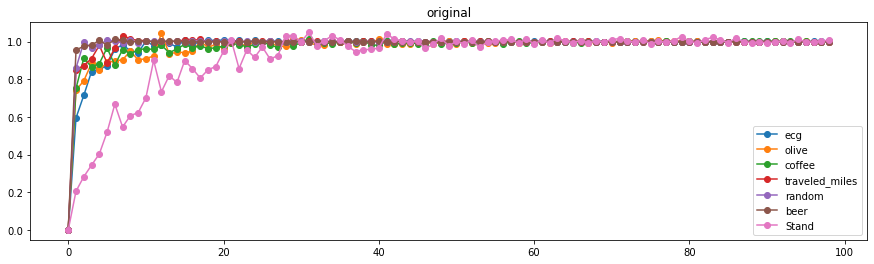

'\nk:  7  val: 0.043833221442765156\nk:  12  val: 0.43605010884332746\nk:  10  val: 0.12310283472908078\nk:  7  val: 0.2888004171153963\nk:  5  val: 0.3127390282377155\nk:  4  val: 0.5807268715157332\n'

In [33]:

alphabet_size_list = [3,5,9]
scaler = MinMaxScaler()
kind_of_error = ['mean_squared_error',"mean_absolute_error"]
reduction_size_list = list(range(100))
for alphabet_size in alphabet_size_list:
    rms_list = []
    rms_list_sax = []

    for i in data_list:
        init = None
        int2 = None
        list_paa, list_paa_sax = plot_rms(reduction_size_list[1:], i,"mean_squared_error", alphabet_size)
        rms_list.append([list_paa,i])
        list_paa_sax_norm = list_paa_sax
        for index,val in enumerate(list_paa_sax_norm):
            if val >= -1.0 and init == None :
                #print('k_sax: ', index, "for:" , i)
                init = 0
        for index,val in enumerate(list_paa):    
            if val >=0.9 and int2 == None :
                #print('k_ts: ', index, "for:" , i)
                int2 = 0
        rms_list_sax.append([list_paa_sax_norm,i])
    multiple_line_plot(rms_list,"original")
    #multiple_line_plot(rms_list_sax, "sax")


#rms_list_smooth = []
#for rms in rms_list:
#    rms_list_smooth.append([smooth_data(rms[0]),rms[1]])
#multiple_line_plot(rms_list_smooth)   
'''
k:  7  val: 0.043833221442765156
k:  12  val: 0.43605010884332746
k:  10  val: 0.12310283472908078
k:  7  val: 0.2888004171153963
k:  5  val: 0.3127390282377155
k:  4  val: 0.5807268715157332
'''

In [17]:
y = [0.0, 0.587907477645177, 0.6765881089163779, 0.7614747933413497, 0.746413235573892, 0.7789822480623736, 0.8495813689600492, 0.9093005758606273, 0.8595474736597187]

In [18]:
from numpy import asarray
np.array(list_paa_sax)
asarray([list_paa_sax])

array([[0.        , 1.4413893 , 1.90677357, 2.17136561, 2.38827724,
        2.73016815, 2.90434457, 2.73871138, 2.85259277, 2.8038107 ,
        2.94704384, 3.08007459, 2.87934222, 3.02084177, 3.04015949,
        3.10304128, 3.09609164, 3.04250723, 3.12192727, 3.07069001,
        3.22109531, 3.29568118, 3.11516102, 3.22054264, 3.17565165,
        3.28386226, 3.20250062, 3.20034525, 3.50777026, 3.43838813,
        3.38378161, 3.48828994, 3.37039084, 3.45910373, 3.5236255 ,
        3.43849283, 3.35623756, 3.33242317, 3.32917457, 3.35682748,
        3.3884125 , 3.57167052, 3.51038074, 3.61074528, 3.47195077,
        3.50001286, 3.42195096, 3.44031298, 3.63031227, 3.42051283,
        3.64542612, 3.49603331, 3.54819159, 3.44391557, 3.51167386,
        3.62803618, 3.59987755, 3.78219145, 3.52369929, 3.58636229,
        3.49754904, 3.70247867, 3.5339241 , 3.63704401, 3.63159022,
        3.55180864, 3.75417684, 3.61384039, 3.66406018, 3.74138476,
        3.79849143, 3.7451944 , 3.66862622, 3.57

In [30]:
d = [[0.        , 0.58790748, 0.67658811, 0.76147479, 0.74641324,
        0.77898225, 0.84958137, 0.90930058, 0.85954747]]
scaler = MinMaxScaler()
#scaler.transform(asarray([list_paa_sax]))
print(scaler.fit_transform(d))

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
list_paa_sax = [i*1000 for i in list_paa_sax]
print(list_paa_sax)
w = np.array(list_paa_sax).reshape(1,-1)
trans = MinMaxScaler()
data = trans.fit_transform(w)
data

In [ ]:
path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/PowerCons_TRAIN.txt"
path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/movies.csv"
path ="/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/walking_running.csv"
path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/FaceAll_TRAIN.txt"
path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/EthanolLevel_TRAIN.txt"
path ="/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/CatsDogs.arff"
path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/stocks.csv"
path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/mitbih_train.csv"
path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/EthanolLevel_TRAIN.txt"
#path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/WormsTwoClass_TEST.txt"
#path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/Rock_TRAIN.txt"
#path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/Car_TRAIN.txt"
#path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/FordA_TEST.txt"
#path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/EyesOpenShut.arff"
#path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/Wafer_TRAIN.txt"
#path = "/Users/steffi/PycharmProjects/MDL/data/StandWalkJump_TRAIN.arff"
#path ="/Users/steffi/PycharmProjects/MDL/data/AtrialFibrillationDimension1_TEST.arff"
#path = "/Users/steffi/PycharmProjects/MDL/data/StandWalkJumpDimension1_TEST.arff"
#path = "/Users/steffi/PycharmProjects/MDL/data/StandWalkJumpDimension2_TEST.arff"
#path = "/Users/steffi/PycharmProjects/MDL/data/StandWalkJumpDimension3_TEST.arff"
#path = "/Users/steffi/PycharmProjects/MDL/data/StandWalkJumpDimension4_TRAIN.arff"
#path ="/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/walking_running.csv"
#path = "/Users/steffi/PycharmProjects/MDL/data/ECGFiveDays_TRAIN.txt"
path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/FaceAll_TRAIN.txt"


if "txt" in path:
    ts = []
    data = np.loadtxt(path)
    #for i in range(300):
    ts.extend(data[0: 20].tolist())
    ts = [j for i in ts for j in i]
    
elif ".arff" in path:
    ts = []
    data1 = arff.loadarff(open(path, 'rt'))
    list_to_append = list(range(12))
    list_to_append2 = list(range(1))
    # ,194,195,198,300,301,302,303]
    df1 = []
    for i in list_to_append:
        for j in list_to_append2:
            df1 = data1[0][i][0][j]
            #df1 = list(data1[0][i])
            print(df1[-1])
            #df1 = df1[:-1]
            #d1 = df1[i:i + 1].values[0][:-1]
            #print(ts)
            ts.extend(df1)
            #print(df1[i:i + 1].values[0][-1])
    
elif ".csv" in path:
    df = pd.read_csv(path)
    print(df.keys())
    ts = list(df["activity"])
    simple_plot(ts, "activity")
    ts = list(df["acceleration_x"])
    simple_plot(ts, "acceleration_x")
simple_plot(ts)

In [ ]:
list(data1[0][30])[:-1]

In [ ]:
i

In [ ]:
data1[0][0][0][1]

[0.0, 1366.811484706997, 2189.6938032040825, 2143.249566368963, 2394.2736913940857, 3211.3023047509087, 3109.4587546306752, 2867.23633641208, 2987.3374159889263, 2855.6314408875032, 3185.6914046946213, 3138.9441846134864, 3201.288748290286, 3246.0910987654515, 3189.394056382713, 3106.4014463667118, 3292.927067782514, 3136.7766693812796, 3372.814132891851, 3089.1598504636086, 3516.144572472939, 3393.00788394311, 3431.756895684515, 3358.5794632853695, 3165.723355075768, 3413.0528542577817, 3467.3339154018868, 3368.7489805473465, 3521.261117266255, 3326.862426178838, 3500.092874485762, 3479.4570444632386, 3433.5925663337393, 3565.9982148977206, 3351.5140652108057, 3365.71918215448, 3563.2764961307134, 3430.1826818182917, 3505.9746678597576, 3329.446957590507, 3372.4582569601935, 3598.99854933447, 3577.3676791605276, 3449.721744724233, 3592.5452364939333, 3431.815186034093, 3511.7896482145197, 3626.9589143238495, 3559.7098627361997, 3491.4521402433, 3642.8634466334533, 3549.0730034527, 363

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]])

No handles with labels found to put in legend.


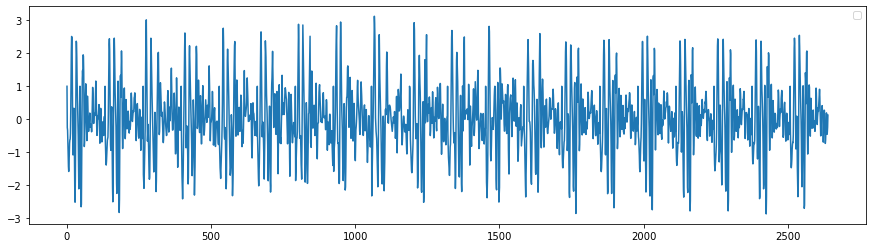

In [99]:
path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/PowerCons_TRAIN.txt"
path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/movies.csv"
path ="/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/walking_running.csv"
path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/FaceAll_TRAIN.txt"
path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/EthanolLevel_TRAIN.txt"
path ="/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/CatsDogs.arff"
path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/stocks.csv"
path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/mitbih_train.csv"
path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/EthanolLevel_TRAIN.txt"
#path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/WormsTwoClass_TEST.txt"
#path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/Rock_TRAIN.txt"
#path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/Car_TRAIN.txt"
#path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/FordA_TEST.txt"
#path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/EyesOpenShut.arff"
#path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/Wafer_TRAIN.txt"
#path = "/Users/steffi/PycharmProjects/MDL/data/StandWalkJump_TRAIN.arff"
#path ="/Users/steffi/PycharmProjects/MDL/data/AtrialFibrillationDimension1_TEST.arff"
#path = "/Users/steffi/PycharmProjects/MDL/data/StandWalkJumpDimension1_TEST.arff"
#path = "/Users/steffi/PycharmProjects/MDL/data/StandWalkJumpDimension2_TEST.arff"
#path = "/Users/steffi/PycharmProjects/MDL/data/StandWalkJumpDimension3_TEST.arff"
#path = "/Users/steffi/PycharmProjects/MDL/data/StandWalkJumpDimension4_TRAIN.arff"
#path ="/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/walking_running.csv"
#path = "/Users/steffi/PycharmProjects/MDL/data/ECGFiveDays_TRAIN.txt"
path = "/Users/steffi/PycharmProjects/MDL_Clustering/MDL_PULP_MOTIF_DETECTION/data/FaceAll_TRAIN.txt"


if "txt" in path:
    ts = []
    data = np.loadtxt(path)
    #for i in range(300):
    ts.extend(data[0: 20].tolist())
    ts = [j for i in ts for j in i]
    
elif ".arff" in path:
    ts = []
    data1 = arff.loadarff(open(path, 'rt'))
    list_to_append = list(range(12))
    list_to_append2 = list(range(1))
    # ,194,195,198,300,301,302,303]
    df1 = []
    for i in list_to_append:
        for j in list_to_append2:
            df1 = data1[0][i][0][j]
            #df1 = list(data1[0][i])
            print(df1[-1])
            #df1 = df1[:-1]
            #d1 = df1[i:i + 1].values[0][:-1]
            #print(ts)
            ts.extend(df1)
            #print(df1[i:i + 1].values[0][-1])
    
elif ".csv" in path:
    df = pd.read_csv(path)
    print(df.keys())
    ts = list(df["activity"])
    simple_plot(ts, "activity")
    ts = list(df["acceleration_x"])
    simple_plot(ts, "acceleration_x")
simple_plot(ts)

In [11]:
list(data1[0][30])[:-1]

IndexError: index 30 is out of bounds for axis 0 with size 15

In [12]:
i

2

In [250]:
data1[0][0][0][1]

(-0.11, -0.11, -0.11, -0.13, -0.14, -0.15, -0.17, -0.15, -0.14, -0.13, -0.12, -0.13, -0.15, -0.16, -0.17, -0.17, -0.15, -0.12, -0.1, -0.11, -0.13, -0.15, -0.18, -0.18, -0.17, -0.14, -0.12, -0.13, -0.15, -0.18, -0.2, -0.23, -0.24, -0.23, -0.22, -0.17, -0.13, -0.07, 0.04, 0.21, 0.45, 0.75, 1.07, 1.37, 1.66, 1.93, 2.16, 2.34, 2.44, 2.47, 2.4, 2.19, 1.83, 1.42, 1.03, 0.71, 0.47, 0.26, 0.12, 0., -0.1, -0.21, -0.32, -0.4, -0.47, -0.51, -0.52, -0.52, -0.51, -0.52, -0.54, -0.57, -0.6, -0.6, -0.58, -0.54, -0.52, -0.51, -0.52, -0.53, -0.53, -0.52, -0.5, -0.46, -0.43, -0.43, -0.44, -0.46, -0.46, -0.47, -0.46, -0.41, -0.38, -0.37, -0.38, -0.4, -0.42, -0.43, -0.42, -0.4, -0.36, -0.35, -0.37, -0.38, -0.4, -0.41, -0.42, -0.41, -0.38, -0.35, -0.33, -0.34, -0.35, -0.36, -0.39, -0.39, -0.37, -0.34, -0.32, -0.32, -0.32, -0.35, -0.37, -0.37, -0.35, -0.31, -0.28, -0.27, -0.28, -0.3, -0.29, -0.28, -0.25, -0.21, -0.18, -0.17, -0.17, -0.18, -0.2, -0.22, -0.22, -0.19, -0.16, -0.14, -0.14, -0.15, -0.17, -0.19, 